In [136]:
import numpy, pandas, pathlib

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib_venn import venn3

import seaborn

from skops.io import load

pathlib.Path('pdf/figure-4').mkdir(exist_ok=True)

### Setup

First let's load the trained models, the Test dataset and performance of the models on the Test dataset which was calculated and written to disc by the last notebook

In [137]:
best_model = {}

for model in ['LR', 'NN', 'XB']:
    best_model[model] = load('models/'+model.lower()+'.skops', trusted=True)

# load the training dataset
X={}
Y={}
Z={}
X['test']={}
Y['test']={}
Z['test']={}
with open('data/ds-test.npy', 'rb') as f:
    Y['test']['input'] = numpy.load(f)
    X['test']['input'] = numpy.load(f)
    Z['test']['input'] = numpy.load(f, allow_pickle=True)

# load the results for the test dataset
results = pandas.read_csv('results-test.csv')
results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio_mean,diagnostic_odds_ratio_std
0,LR,test,78.640777,NaN,70.103093,NaN,82.684416,NaN,68,29,22,81,NaN,8.633229,0
1,NN,test,76.699029,NaN,67.010309,NaN,79.861876,NaN,65,32,24,79,NaN,6.686198,0
2,XB,test,77.669903,NaN,75.257732,NaN,82.764488,NaN,73,24,23,80,NaN,10.579710,0
3,SP,test,95.145631,NaN,97.938144,NaN,NaN,NaN,95,2,5,98,NaN,931.000000,0


In [138]:
errors = {}
errors['vme'] = {}
errors['me'] = {}
correct = {}
correct['R'] = {}
correct['S'] = {}

for model in ['LR', 'NN', 'XB']:

    y_predicted = best_model[model].predict(X['test']['input'])

    errors['vme'][model] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==0)])
    
    errors['me'][model] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==1)])

    correct['R'][model] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==1)])

    correct['S'][model] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==0)])

    print(model, '| very major errors =', len(errors['vme'][model]), '| major errors =', len(errors['me'][model]))

LR | very major errors = 22 | major errors = 29
NN | very major errors = 24 | major errors = 32
XB | very major errors = 23 | major errors = 24


In [139]:
for i in ['vme','me']:
    fig = plt.figure(figsize=(6,6))
    axes = venn3([errors[i]['LR'], errors[i]['NN'], errors[i]['XB']], set_labels=['LinReg','MLP','XGB'], set_colors=('#e41a1c','#377eb8','#4daf4a'))
    fig.savefig('pdf/figure-4/fig-4-venn-'+i+'.pdf', bbox_inches="tight")
    plt.close()

In [140]:
very_major_errors = errors['vme']['NN'].intersection(errors['vme']['LR'].intersection(errors['vme']['XB']))
major_errors = errors['me']['NN'].intersection(errors['me']['LR'].intersection(errors['me']['XB']))
correct_R = correct['R']['NN'].intersection(correct['R']['LR'].intersection(correct['R']['XB']))
correct_S = correct['S']['NN'].intersection(correct['S']['LR'].intersection(correct['S']['XB']))

In [141]:
'resid '+' '.join(i[1:-1] for i in very_major_errors)

'resid 32 112 93 115 127 76 118 30 110 29 38 88 18 82 174'

In [142]:
'resid '+' '.join(i[1:-1] for i in major_errors)

'resid 35 28 172 178 46 11 11 35 58 79 17 32 19 17 23'

Now back the dataset with the features and label so we can analyse which features led to the discrepancies

In [143]:
df = pandas.read_csv('data/ds-traintest-phen-features.csv')
df.loc[df.mutation.isin(very_major_errors), 'label'] = 'vme'
df.loc[df.mutation.isin(major_errors), 'label'] = 'me'
df.loc[df.mutation.isin(correct_R), 'label'] = 'R'
df.loc[df.mutation.isin(correct_S), 'label'] = 'S'

df.label.value_counts()

R      73
S      55
me     15
vme    15
Name: label, dtype: int64

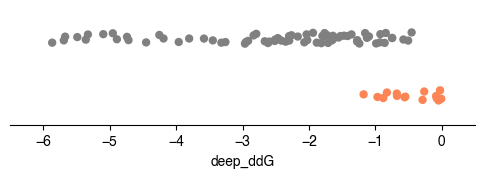

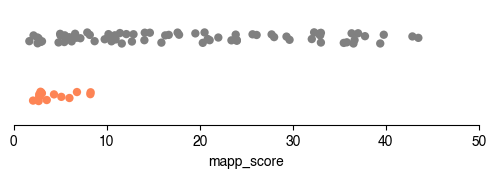

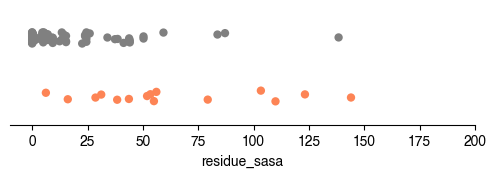

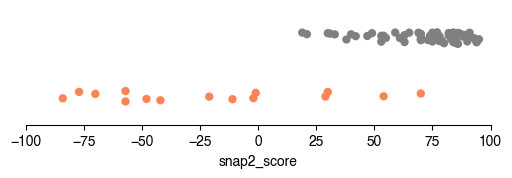

In [144]:
fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='deep_ddG', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-6.5,0.5])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-deepDDG.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='mapp_score', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([0,50])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-mapp.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='residue_sasa', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-10,200])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-sasa.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='snap2_score', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-100,100])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-snap2.pdf', bbox_inches='tight', transparent=True)

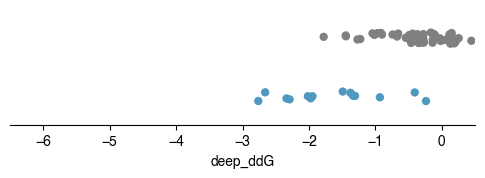

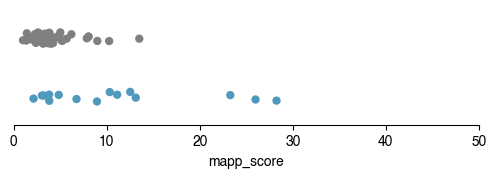

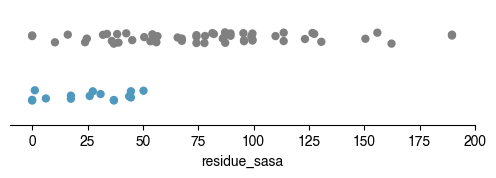

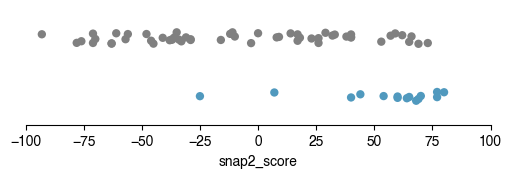

In [145]:
fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='deep_ddG', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-6.5,0.5])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-deepDDG.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='mapp_score', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([0,50])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-mapp.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='residue_sasa', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-10,200])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-sasa.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='snap2_score', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-100,100])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-snap2.pdf', bbox_inches='tight', transparent=True)

Repeat, but include the results of SuspectPZA